In [2]:
# Import necessary libraries
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib import _contour
import plotly.graph_objects as go
from lal.antenna import AntennaResponse
from astropy.time import Time, TimeDelta
from astropy.coordinates import SkyCoord, EarthLocation, AltAz


# LVK response for a given date, ra, dec

- May 2025 Original Antenna Response from from Jade Powell 
- June 2025 Modified by Anais Moller to scan the southern sky

In [3]:

# Define constants
DETECTORS = ['H1', 'L1', 'V1']
# Rubin Observatory (Cerro Pachón, Chile)
LOCATION = EarthLocation(
    lat=-30.2446 * u.deg,
    lon=-70.7494 * u.deg,
    height=2663 * u.m
)

# Function to calculate antenna response for a given RA, Dec, and time
def calculate_antenna_response(ras, decs, times):
    antenna_power_grid = np.zeros((len(decs), len(ras), len(times)))
    for i, dec in enumerate(decs):
        for j, ra in enumerate(ras):
            dic_resp = {
                detector: AntennaResponse(
                    detector,
                    ra=np.radians(ra),
                    dec=np.radians(dec),
                    psi=0,
                    times=times
                )
                for detector in DETECTORS
            }
            network_antenna_power_pattern = np.sum(
                [dic_resp[detector].plus**2 + dic_resp[detector].cross**2 for detector in dic_resp],
                axis=0
            )
            antenna_power_grid[i, j, :] = network_antenna_power_pattern
    return antenna_power_grid

import matplotlib.pyplot as plt

def plot_antenna_power_map(
    antenna_power_grid,
    ras,
    decs,
    ra_band,
    dec_band,
    idx_time=0,
    idx_arr=None,
    extra_ras=None,
    extra_decs=None,
    ax=None
):
    # Use provided axis or create one
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 3))

    # Plot the antenna power map
    im = ax.imshow(
        antenna_power_grid[:, :, idx_time],
        extent=[ras.min(), ras.max(), decs.min(), decs.max()],
        aspect='auto',
        origin='lower',
        cmap='viridis'
    )

    # Optional: overlay extra points
    if extra_ras is not None and extra_decs is not None:
        ax.scatter(extra_ras, extra_decs, color='grey', s=10, alpha=0.3, label='Extra Points')

    # Axis labels and title
    ax.set_xlabel('Right Ascension (deg)')
    ax.set_ylabel('Declination (deg)')
    if idx_arr is not None:
        idx_title = f'{idx_arr[idx_time]}'
    else:
        idx_title = idx_time
    ax.set_title(f'Antenna Power at {idx_title}', fontsize=8)

    # Overlay galactic plane
    ax.fill(ra_band, dec_band, color='red', alpha=0.3)

    ax.set_ylim(-80, 0)

    # Only add colorbar if not plotting in subplots
    if ax is None:
        plt.colorbar(im, ax=ax, label='Antenna Power')
        plt.tight_layout()
        plt.show()

    return im


# Function to calculate galactic plane polygon
def calculate_galactic_plane(wrapped=False):
    l_vals = np.linspace(0, 360, 1000)
    b_upper = 10 * np.ones_like(l_vals)
    b_lower = -10 * np.ones_like(l_vals)
    upper_edge = SkyCoord(l=l_vals * u.deg, b=b_upper * u.deg, frame='galactic').icrs
    lower_edge = SkyCoord(l=l_vals[::-1] * u.deg, b=b_lower[::-1] * u.deg, frame='galactic').icrs
    ra_band = np.concatenate([upper_edge.ra.deg, lower_edge.ra.deg]) % 360
    dec_band = np.concatenate([upper_edge.dec.deg, lower_edge.dec.deg])
    if wrapped:
        # Wrap RA for Mollweide projection
        ra_band_wrapped = (ra_band + 180) % 360 - 180  # wrap for Mollweide
        return ra_band_wrapped, dec_band
    else:
        return ra_band, dec_band

# Function to calculate day-night boundary
def calculate_day_night_boundary(ras, decs, defined_time):
    RA_grid, DEC_grid = np.meshgrid(ras, decs)
    sky_coords = SkyCoord(ra=RA_grid * u.deg, dec=DEC_grid * u.deg, frame='icrs')
    altaz = sky_coords.transform_to(AltAz(obstime=defined_time, location=LOCATION))
    alt = altaz.alt.value
    cs = _contour.QuadContourGenerator(RA_grid, DEC_grid, alt, None, False, 0)
    contours = cs.create_contour(0)
    return contours

# plotly

def calculate_night_region_contours(ras, decs, defined_time, location):
    """
    Compute the night region contours (altitude < 0°) from a grid of RA/Dec values.
    
    Parameters:
    - ras: 1D array of Right Ascension in degrees
    - decs: 1D array of Declination in degrees
    - defined_time: astropy.time.Time object (UTC time)
    - location: astropy.coordinates.EarthLocation of the observatory
    
    Returns:
    - contours: List of numpy arrays representing the contour lines at alt = 0°
    """
    import numpy as np
    from astropy.coordinates import SkyCoord, AltAz
    import astropy.units as u
    from matplotlib import _contour

    # Create the RA/Dec grid
    RA_grid, DEC_grid = np.meshgrid(ras, decs)

    # Convert to AltAz to get altitude above horizon
    sky_coords = SkyCoord(ra=RA_grid * u.deg, dec=DEC_grid * u.deg, frame='icrs')
    altaz = sky_coords.transform_to(AltAz(obstime=defined_time, location=location))
    alt = altaz.alt.reshape(RA_grid.shape)
    # Use contour generator to get 0° altitude contour (i.e., the horizon)
    try:
        cs = _contour.QuadContourGenerator(RA_grid, DEC_grid, alt, None, False, 0)
        contours = cs.create_contour(0)  # Contour for alt = 0 (horizon)
    except Exception as e:
        print(f"Contour generation failed: {e}")
        contours = []

    return contours


def plot_antenna_power_mollweide(
    antenna_power_grid, ras, decs,
    galactic_ra_band, galactic_dec_band,
    night_contours=None, time_index=0
):
    RA_grid, DEC_grid = np.meshgrid(ras, decs)
    ra_flat = RA_grid.flatten()
    dec_flat = DEC_grid.flatten()
    power_flat = antenna_power_grid[:, :, time_index].flatten()
    ra_flat_wrapped = (ra_flat + 180) % 360 - 180

    fig = go.Figure()

    # Antenna Power Map
    fig.add_trace(go.Scattergeo(
        lon=ra_flat_wrapped,
        lat=dec_flat,
        mode='markers',
        marker=dict(
            size=6,
            color=power_flat,
            colorscale='Viridis',
            colorbar=dict(title='Power'),
            cmin=power_flat.min(),
            cmax=power_flat.max()
        ),
        hoverinfo='text',
        text=[f'RA: {ra:.1f}°, Dec: {dec:.1f}°, Power: {p:.2f}' for ra, dec, p in zip(ra_flat, dec_flat, power_flat)],
        name='Antenna Power'
    ))

    # Galactic Plane
    fig.add_trace(go.Scattergeo(
        lon=galactic_ra_band,
        lat=galactic_dec_band,
        mode='lines',
        fill='toself',
        fillcolor='rgba(200, 100, 100, 0.3)',
        line=dict(width=0),
        hoverinfo='skip',
        showlegend=True,
        name='Galactic Plane'
    ))

    # Night Region (if provided)
    if night_contours is not None:
        # Plot the contour as a filled shadow
        for segment in night_contours:
            ra_contour = segment[:, 0]
            dec_contour = segment[:, 1]

            # Wrap RA to [-180, 180] for Mollweide
            ra_wrapped = (ra_contour + 180) % 360 - 180

            fig.add_trace(go.Scattergeo(
                lon=ra_wrapped,
                lat=dec_contour,
                mode='lines',
                fill='toself',
                fillcolor='rgba(0, 0, 0, 0.4)',
                line=dict(width=0),
                hoverinfo='skip',
                showlegend=False,
                name='Night Region'
            ))


    fig.update_geos(
        projection_type="mollweide",
        showland=False,
        showcoastlines=False,
        lataxis_showgrid=True,
        lonaxis_showgrid=True,
    )

    fig.update_layout(
        title=f'Antenna Power Pattern + Galactic Plane + Night Region {time_index}',
        geo=dict(resolution=50, showframe=False),
        height=300,
        width=600,
        margin={"r":0,"t":30,"l":0,"b":0}
    )

    fig.show()

# Main

In [4]:
# Define time range
t0 = Time('2025-07-01 00:00:00', format='iso', scale='utc')
t1 = Time('2025-09-10 23:00:02', format='iso', scale='utc')

delta_14d = TimeDelta(14 * 24 * 3600, format='sec')  # 14 days

times_list = []
current_time = t0
while current_time <= t1:
    times_list.append(current_time)
    current_time += delta_14d

times = Time(times_list)
times_gps_array = times.gps  # numpy array of GPS seconds (floats)

# Dictionary mapping index to full Time object
index_time_dict = {i: t for i, t in enumerate(times)}

print("GPS times array:", times_gps_array)
print("Index to Time dict:", index_time_dict)

# Create reverse lookup: GPS time → index
gps_to_index = {t.gps: i for i, t in index_time_dict.items()}


# Define RA and Dec grid
ras = np.arange(0, 360, 10)
decs = np.arange(-90, 20, 10)

# Calculate antenna response
antenna_power_grid = calculate_antenna_response(ras, decs, times_gps_array)


GPS times array: [1.43536322e+09 1.43657282e+09 1.43778242e+09 1.43899202e+09
 1.44020162e+09 1.44141122e+09]
Index to Time dict: {0: <Time object: scale='utc' format='iso' value=2025-07-01 00:00:00.000>, 1: <Time object: scale='utc' format='iso' value=2025-07-15 00:00:00.000>, 2: <Time object: scale='utc' format='iso' value=2025-07-29 00:00:00.000>, 3: <Time object: scale='utc' format='iso' value=2025-08-12 00:00:00.000>, 4: <Time object: scale='utc' format='iso' value=2025-08-26 00:00:00.000>, 5: <Time object: scale='utc' format='iso' value=2025-09-09 00:00:00.000>}


In [5]:

# # Matplotlib
# # Calculate galactic plane
# galactic_ra_band, galactic_dec_band = calculate_galactic_plane(wrapped=False)

# # Plot antenna power map
# plot_antenna_power_map(antenna_power_grid, ras, decs, galactic_ra_band, galactic_dec_band)


In [6]:
# Plotly
# Calculate galactic plane
galactic_ra_band, galactic_dec_band = calculate_galactic_plane(wrapped=True)

ras_contour = np.linspace(0, 360, 361)  # 1° steps
decs_contour = np.linspace(-90, 90, 181)

for tim in times:
    night_contours = calculate_night_region_contours(ras_contour, decs_contour, tim.utc, LOCATION)
    # find time index
    idx_time = gps_to_index.get(tim.gps)
    # Plot antenna power map
    plot_antenna_power_mollweide(
    antenna_power_grid, ras, decs,
    galactic_ra_band, galactic_dec_band,
    night_contours=night_contours, time_index=idx_time
    )

# Search for fields to propose
- Mean/median power: wrong as power moves through the night somewhere between dec -30,-50. And here I am using only one time in the night
- Select a range of dec, look visibility in Rubin in the template (SV July-September) and potential ToO period (September-November) + avoid galaxy

### 1. Mean/median (wrong)
Mean/median power: wrong as power moves through the night somewhere between dec -30,-50. And here I am using only one time in the night

In [7]:
# How many delta days to probe
step_days = 3  # Number of days to probe
# Time ranges for Rubin
visibility_start = Time('2025-07-01 00:00:00', format='iso', scale='utc')
visibility_end = Time('2025-09-01 00:00:00', format='iso', scale='utc')
visibility_times = Time(np.arange(visibility_start.jd, visibility_end.jd, step_days), format='jd', scale='utc')

power_start = Time('2025-09-01 00:00:00', format='iso', scale='utc')
power_end = Time('2025-11-30 00:00:00', format='iso', scale='utc')
power_times = Time(np.arange(power_start.jd, power_end.jd, step_days), format='jd', scale='utc')

# RA/Dec Grid (10-degree spacing)
ras = np.arange(0, 360, 10)
decs = np.arange(-90, 30, 10)
RA_grid, DEC_grid = np.meshgrid(ras, decs)
ra_flat = RA_grid.flatten()
dec_flat = DEC_grid.flatten()

# Sky coordinates
sky_coords = SkyCoord(ra=ra_flat*u.deg, dec=dec_flat*u.deg, frame='icrs')

# Visibility mask
visible_mask = np.zeros(len(sky_coords), dtype=bool)
for t in visibility_times:
    altaz = sky_coords.transform_to(AltAz(obstime=t, location=LOCATION))
    visible_mask |= (altaz.alt > 20*u.deg)

#### # MEAN IS WRONG AS THE HIGH POWER PATCH MOVES THROUGH THE NIGHT SKY
antenna_power = calculate_antenna_response(ras, decs, power_times.gps)# shape decs,ras,times
mean_antenna_power = np.median(antenna_power, axis=2) # shape decs,ras
mean_antenna_power_flat = mean_antenna_power.flatten()

In [8]:

# Combine visibility mask with mean antenna power
combined_mask = visible_mask & (mean_antenna_power_flat >1.3)

# Extract matching sky positions
selected_coords = sky_coords[combined_mask]
selected_power = mean_antenna_power_flat[combined_mask]

# Output sample
for i in range(min(5, len(selected_coords))):
    print(f"RA: {selected_coords[i].ra.deg:.1f}°, Dec: {selected_coords[i].dec.deg:.1f}°, Mean Power: {selected_power[i]:.2f}")


RA: 0.0°, Dec: -90.0°, Mean Power: 1.40
RA: 10.0°, Dec: -90.0°, Mean Power: 1.40
RA: 20.0°, Dec: -90.0°, Mean Power: 1.40
RA: 30.0°, Dec: -90.0°, Mean Power: 1.40
RA: 40.0°, Dec: -90.0°, Mean Power: 1.40


In [9]:

def plot_antenna_power_mollweide_v2(
    antenna_power_grid, ras, decs,
    galactic_ra_band, galactic_dec_band,
    night_contours=None,
    time_index=0,
    selected_coords=None  # New argument
):
    RA_grid, DEC_grid = np.meshgrid(ras, decs)
    ra_flat = RA_grid.flatten()
    dec_flat = DEC_grid.flatten()
    power_flat = antenna_power_grid[:, :, time_index].flatten()
    ra_flat_wrapped = (ra_flat + 180) % 360 - 180

    fig = go.Figure()

    # Antenna Power Map
    fig.add_trace(go.Scattergeo(
        lon=ra_flat_wrapped,
        lat=dec_flat,
        mode='markers',
        marker=dict(
            size=6,
            color=power_flat,
            colorscale='Viridis',
            colorbar=dict(title='Power'),
            cmin=power_flat.min(),
            cmax=power_flat.max()
        ),
        hoverinfo='text',
        text=[f'RA: {ra:.1f}°, Dec: {dec:.1f}°, Power: {p:.2f}' for ra, dec, p in zip(ra_flat, dec_flat, power_flat)],
        name='Antenna Power'
    ))

    # Galactic Plane
    fig.add_trace(go.Scattergeo(
        lon=galactic_ra_band,
        lat=galactic_dec_band,
        mode='lines',
        fill='toself',
        fillcolor='rgba(200, 100, 100, 0.3)',
        line=dict(width=0),
        hoverinfo='skip',
        showlegend=True,
        name='Galactic Plane'
    ))

    # Night Region (if provided)
    if night_contours is not None:
        for segment in night_contours:
            ra_contour = segment[:, 0]
            dec_contour = segment[:, 1]
            ra_wrapped = (ra_contour + 180) % 360 - 180
            fig.add_trace(go.Scattergeo(
                lon=ra_wrapped,
                lat=dec_contour,
                mode='lines',
                fill='toself',
                fillcolor='rgba(0, 0, 0, 0.4)',
                line=dict(width=0),
                hoverinfo='skip',
                showlegend=False,
                name='Night Region'
            ))

    # Selected Regions Overlay
    if selected_coords is not None and len(selected_coords) > 0:
        selected_ra = selected_coords.ra.deg
        selected_dec = selected_coords.dec.deg
        selected_ra_wrapped = (selected_ra + 180) % 360 - 180

        fig.add_trace(go.Scattergeo(
            lon=selected_ra_wrapped,
            lat=selected_dec,
            mode='markers',
            marker=dict(size=8, color='red', symbol='x',opacity=0.5),
            name='Selected Sky Region',
            hoverinfo='text',
            text=[f"RA: {ra:.1f}°, Dec: {dec:.1f}°" for ra, dec in zip(selected_ra, selected_dec)]
        ))

    fig.update_geos(
        projection_type="mollweide",
        showland=False,
        showcoastlines=False,
        lataxis_showgrid=True,
        lonaxis_showgrid=True,
    )

    fig.update_layout(
        title='Antenna Power Pattern + Galactic Plane + Night Region + Selected Sky',
        geo=dict(resolution=50, showframe=False),
        height=300,
        width=600,
        margin={"r": 0, "t": 30, "l": 0, "b": 0}
    )

    fig.show()


Observation time: 2025-07-01 00:00:00.000
Observation time: 2025-07-04 00:00:00.000
Observation time: 2025-07-07 00:00:00.000
Observation time: 2025-07-10 00:00:00.000
Observation time: 2025-07-13 00:00:00.000
Observation time: 2025-07-16 00:00:00.000
Observation time: 2025-07-19 00:00:00.000
Observation time: 2025-07-22 00:00:00.000
Observation time: 2025-07-25 00:00:00.000
Observation time: 2025-07-28 00:00:00.000
Observation time: 2025-07-31 00:00:00.000
Observation time: 2025-08-03 00:00:00.000
Observation time: 2025-08-06 00:00:00.000
Observation time: 2025-08-09 00:00:00.000
Observation time: 2025-08-12 00:00:00.000
Observation time: 2025-08-15 00:00:00.000
Observation time: 2025-08-18 00:00:00.000
Observation time: 2025-08-21 00:00:00.000
Observation time: 2025-08-24 00:00:00.000
Observation time: 2025-08-27 00:00:00.000
Observation time: 2025-08-30 00:00:00.000


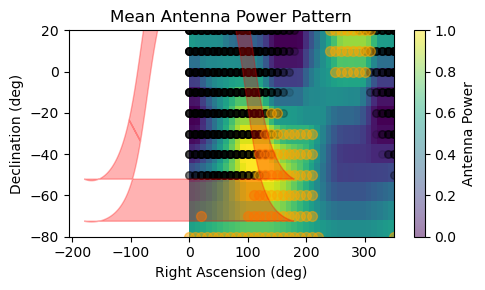

In [10]:
plt.figure(figsize=(5, 3))
plt.imshow(
    mean_antenna_power,  # 2D slice at time index idx_time
    extent=[ras.min(), ras.max(), decs.min(), decs.max()],
    aspect='auto',
    origin='lower',
    cmap='viridis'
)
# Overlay night region as scatter
for obs_time in visibility_times:
    print(f"Observation time: {obs_time.iso}")
    altaz = sky_coords.transform_to(AltAz(obstime=obs_time, location=LOCATION))

    # Identify points below horizon (i.e., night sky)
    night_mask = altaz.alt < 0*u.deg
    ra_night = RA_grid.flatten()[night_mask]
    dec_night = DEC_grid.flatten()[night_mask]
    plt.scatter(ra_night, dec_night, color='black', alpha=0.1, s=30, label='Night Sky')

plt.scatter(
    selected_coords.ra.deg, selected_coords.dec.deg,
    color='orange', alpha=0.5, s=50, label='Selected Regions'
)
plt.colorbar(label='Antenna Power')
plt.xlabel('Right Ascension (deg)')
plt.ylabel('Declination (deg)')
plt.title(f'Mean Antenna Power Pattern')
plt.fill(galactic_ra_band, galactic_dec_band, color='red', alpha=0.3)
plt.ylim(-80, 20)
plt.tight_layout()
plt.show()

# Option 2
Select a range of dec, look visibility in Rubin in the template (SV July-September) and potential ToO period (September-November) + avoid galaxy

### For a given night

In [11]:
# Define time range
t0 = Time('2025-07-10 10:00:00', format='iso', scale='utc') # around 5pm that day?
t1 = Time('2025-07-11 11:00:02', format='iso', scale='utc')

deltasubnight = TimeDelta(0.1 * 24 * 3600, format='sec')  # 14 days

times_list = []
current_time = t0
while current_time <= t1:
    times_list.append(current_time)
    current_time += deltasubnight

times = Time(times_list)
times_gps_array = times.gps  # numpy array of GPS seconds (floats)

# Dictionary mapping index to full Time object
index_time_dict = {i: t for i, t in enumerate(times)}

print("GPS times array:", times_gps_array)
print("Index to Time dict:", index_time_dict)

# Create reverse lookup: GPS time → index
gps_to_index = {t.gps: i for i, t in index_time_dict.items()}


# Define RA and Dec grid
ras = np.arange(0, 360, 10)
decs = np.arange(-90, 20, 10)

# Calculate antenna response
antenna_power_grid = calculate_antenna_response(ras, decs, times_gps_array)

# # Matplotlib
# # Calculate galactic plane
galactic_ra_band, galactic_dec_band = calculate_galactic_plane(wrapped=False)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 3*nrows), constrained_layout=True)
axes = axes.flatten()  # flatten to index easily
# Loop over times and plot each antenna power map
for idx in range(n_times):
    ax = axes[idx]
    plot_antenna_power_map(
        antenna_power_grid, ras, decs,
        galactic_ra_band, galactic_dec_band,
        idx_time=idx, idx_arr=times,
        ax=ax  # this is key to using subplots
    )
    ax.set_title(times[idx].iso[:16], fontsize=8)

# Remove unused subplots
for ax in axes[n_times:]:
    fig.delaxes(ax)

plt.suptitle("Antenna Power Maps Over Time", fontsize=16)
plt.show()


GPS times array: [1.43617682e+09 1.43618546e+09 1.43619410e+09 1.43620274e+09
 1.43621138e+09 1.43622002e+09 1.43622866e+09 1.43623730e+09
 1.43624594e+09 1.43625458e+09 1.43626322e+09]
Index to Time dict: {0: <Time object: scale='utc' format='iso' value=2025-07-10 10:00:00.000>, 1: <Time object: scale='utc' format='iso' value=2025-07-10 12:24:00.000>, 2: <Time object: scale='utc' format='iso' value=2025-07-10 14:48:00.000>, 3: <Time object: scale='utc' format='iso' value=2025-07-10 17:12:00.000>, 4: <Time object: scale='utc' format='iso' value=2025-07-10 19:36:00.000>, 5: <Time object: scale='utc' format='iso' value=2025-07-10 22:00:00.000>, 6: <Time object: scale='utc' format='iso' value=2025-07-11 00:24:00.000>, 7: <Time object: scale='utc' format='iso' value=2025-07-11 02:48:00.000>, 8: <Time object: scale='utc' format='iso' value=2025-07-11 05:12:00.000>, 9: <Time object: scale='utc' format='iso' value=2025-07-11 07:36:00.000>, 10: <Time object: scale='utc' format='iso' value=2025

NameError: name 'nrows' is not defined

GPS times array: [1.44153362e+09 1.44154226e+09 1.44155090e+09 1.44155954e+09
 1.44156818e+09 1.44157682e+09 1.44158546e+09 1.44159410e+09
 1.44160274e+09 1.44161138e+09 1.44162002e+09]
Index to Time dict: {0: <Time object: scale='utc' format='iso' value=2025-09-10 10:00:00.000>, 1: <Time object: scale='utc' format='iso' value=2025-09-10 12:24:00.000>, 2: <Time object: scale='utc' format='iso' value=2025-09-10 14:48:00.000>, 3: <Time object: scale='utc' format='iso' value=2025-09-10 17:12:00.000>, 4: <Time object: scale='utc' format='iso' value=2025-09-10 19:36:00.000>, 5: <Time object: scale='utc' format='iso' value=2025-09-10 22:00:00.000>, 6: <Time object: scale='utc' format='iso' value=2025-09-11 00:24:00.000>, 7: <Time object: scale='utc' format='iso' value=2025-09-11 02:48:00.000>, 8: <Time object: scale='utc' format='iso' value=2025-09-11 05:12:00.000>, 9: <Time object: scale='utc' format='iso' value=2025-09-11 07:36:00.000>, 10: <Time object: scale='utc' format='iso' value=2025

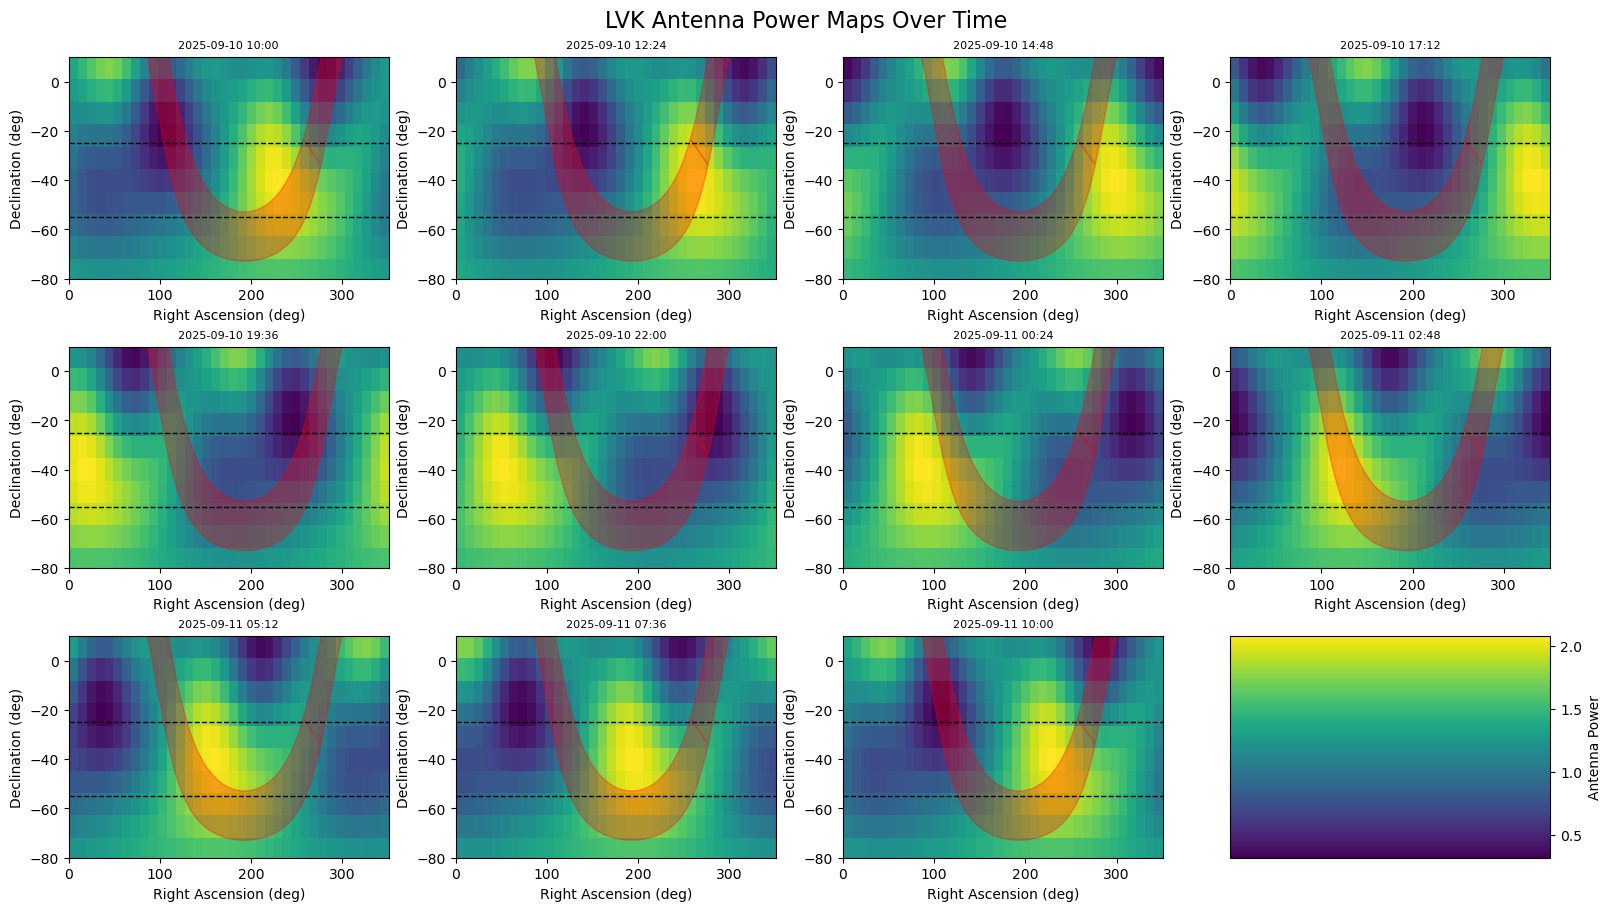

In [ ]:
# Define time range
t0 = Time('2025-09-10 10:00:00', format='iso', scale='utc') # around 5pm that day?
t1 = Time('2025-09-11 11:00:02', format='iso', scale='utc')

deltasubnight = TimeDelta(0.1 * 24 * 3600, format='sec')  # 14 days

times_list = []
current_time = t0
while current_time <= t1:
    times_list.append(current_time)
    current_time += deltasubnight

times = Time(times_list)
times_gps_array = times.gps  # numpy array of GPS seconds (floats)

# Dictionary mapping index to full Time object
index_time_dict = {i: t for i, t in enumerate(times)}

print("GPS times array:", times_gps_array)
print("Index to Time dict:", index_time_dict)

# Create reverse lookup: GPS time → index
gps_to_index = {t.gps: i for i, t in index_time_dict.items()}


# Define RA and Dec grid
ras = np.arange(0, 360, 10)
decs = np.arange(-90, 20, 10)

# Calculate antenna response
antenna_power_grid = calculate_antenna_response(ras, decs, times_gps_array)

# # Matplotlib
# # Calculate galactic plane
galactic_ra_band, galactic_dec_band = calculate_galactic_plane(wrapped=False)


# Prepare subplots
n_times = len(times)
ncols = 4
nrows = int(np.ceil(n_times / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 3*nrows), constrained_layout=True)
axes = axes.flatten()  # flatten to index easily

# Loop over times and plot each antenna power map
for idx in range(n_times):
    ax = axes[idx]
    last_im = plot_antenna_power_map(
        antenna_power_grid, ras, decs,
        galactic_ra_band, galactic_dec_band,
        idx_time=idx, idx_arr=times,
        ax=ax  # this is key to using subplots
    )
    ax.hlines(-25, 0, 360, color='black', linestyle='--', linewidth=1)
    ax.hlines(-55, 0, 360, color='black', linestyle='--', linewidth=1)
    ax.set_ylim(-80, 10)
    ax.set_xlim(0, 351)
    ax.set_title(times[idx].iso[:16], fontsize=8)

# Colorbar in unused space
if n_times < len(axes):
    cax = axes[n_times]
else:
    fig.subplots_adjust(right=0.88)
    cax = fig.add_axes([0.9, 0.15, 0.02, 0.7])

fig.colorbar(last_im, cax=cax, label='Antenna Power')

# Remove unused axes, except the one used for colorbar
for ax in axes[n_times+1:]:
    fig.delaxes(ax)

plt.suptitle("LVK Antenna Power Maps Over Time", fontsize=16)
plt.show()


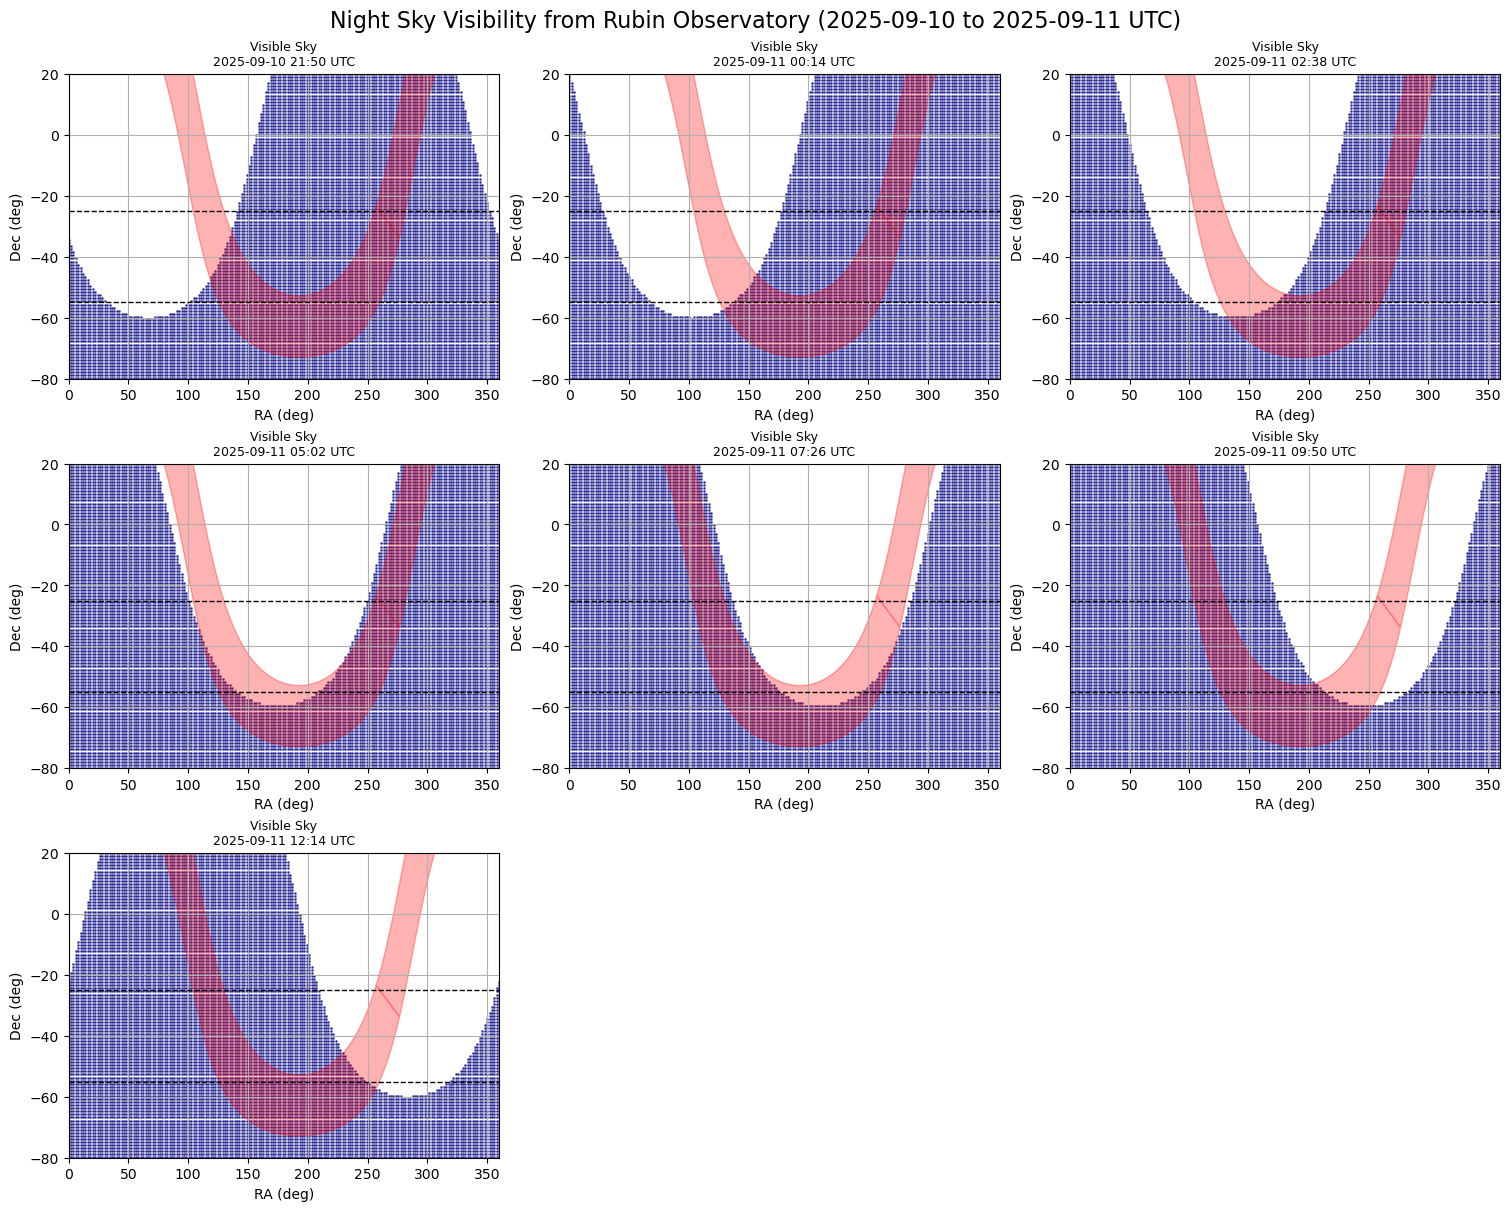

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time, TimeDelta
from astropy.coordinates import SkyCoord, AltAz, EarthLocation
import astropy.units as u

# 1. Rubin Observatory location
LOCATION = EarthLocation(lat=-30.2446*u.deg, lon=-70.7494*u.deg, height=2663*u.m)

# 2. Time range: 2025-09-10 night at Rubin (UTC)
t0 = Time('2025-09-10 21:50:00', scale='utc')  # sunset (UTC)
t1 = Time('2025-09-11 11:30:00', scale='utc')  # sunrise (UTC)

delta_t = TimeDelta(0.1 * u.day)  # 0.1 day = 2.4 hours
times = t0 + np.arange(0, (t1 - t0)/delta_t + 1) * delta_t

# 3. Sky grid (RA/Dec)
ras = np.linspace(0, 360, 180)
decs = np.linspace(-90, 20, 110)
RA_grid, DEC_grid = np.meshgrid(ras, decs)
sky_coords = SkyCoord(ra=RA_grid.flatten()*u.deg, dec=DEC_grid.flatten()*u.deg, frame='icrs')

# 4. Plot setup
n_times = len(times)
ncols = 3
nrows = int(np.ceil(n_times / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows), constrained_layout=True)
axes = axes.flatten()

# 5. Loop over time steps and plot visible sky
for i, time in enumerate(times):
    ax = axes[i]

    altaz = sky_coords.transform_to(AltAz(obstime=time, location=LOCATION))
    mask_visible = altaz.alt > 0*u.deg  # Only above the horizon

    ra_visible = RA_grid.flatten()[mask_visible]
    dec_visible = DEC_grid.flatten()[mask_visible]

    ax.scatter(ra_visible, dec_visible, s=1, color='navy', alpha=0.6)
    ax.fill(galactic_ra_band, galactic_dec_band, color='red', alpha=0.3)

    ax.hlines(-25, 0, 360, color='black', linestyle='--', linewidth=1)
    ax.hlines(-55, 0, 360, color='black', linestyle='--', linewidth=1)
    ax.set_xlim(0, 360)
    ax.set_ylim(-80, 20)
    ax.set_title(f"Visible Sky\n{time.iso[:16]} UTC", fontsize=9)
    ax.set_xlabel("RA (deg)")
    ax.set_ylabel("Dec (deg)")
    ax.grid(True)

# Remove unused subplots
for ax in axes[n_times:]:
    fig.delaxes(ax)

plt.suptitle("Night Sky Visibility from Rubin Observatory (2025-09-10 to 2025-09-11 UTC)", fontsize=16)
plt.show()


# add ecliptic


GPS times array: [1.44153362e+09 1.44154226e+09 1.44155090e+09 1.44155954e+09
 1.44156818e+09 1.44157682e+09 1.44158546e+09 1.44159410e+09
 1.44160274e+09 1.44161138e+09 1.44162002e+09]
Index to Time dict: {0: <Time object: scale='utc' format='iso' value=2025-09-10 10:00:00.000>, 1: <Time object: scale='utc' format='iso' value=2025-09-10 12:24:00.000>, 2: <Time object: scale='utc' format='iso' value=2025-09-10 14:48:00.000>, 3: <Time object: scale='utc' format='iso' value=2025-09-10 17:12:00.000>, 4: <Time object: scale='utc' format='iso' value=2025-09-10 19:36:00.000>, 5: <Time object: scale='utc' format='iso' value=2025-09-10 22:00:00.000>, 6: <Time object: scale='utc' format='iso' value=2025-09-11 00:24:00.000>, 7: <Time object: scale='utc' format='iso' value=2025-09-11 02:48:00.000>, 8: <Time object: scale='utc' format='iso' value=2025-09-11 05:12:00.000>, 9: <Time object: scale='utc' format='iso' value=2025-09-11 07:36:00.000>, 10: <Time object: scale='utc' format='iso' value=2025

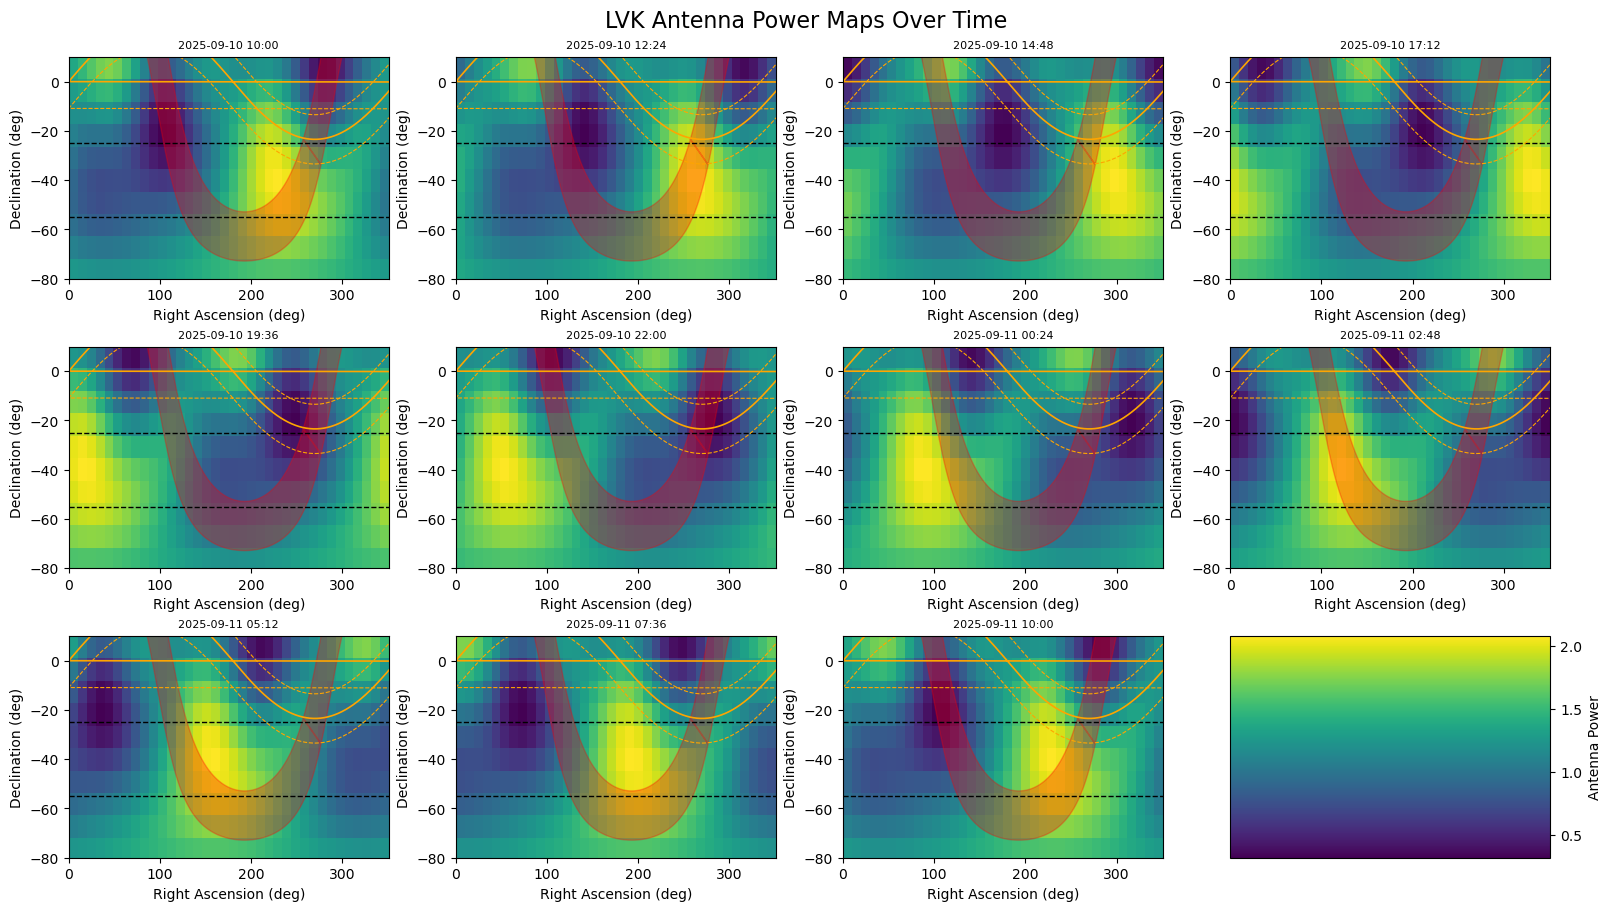

In [ ]:
from astropy.coordinates import SkyCoord, GeocentricTrueEcliptic
import astropy.units as u

# Define ecliptic longitude range (0° to 360°)
lon = np.linspace(0, 360, 1000) * u.deg

# Ecliptic latitude bands: 0°, +10°, -10°
lat_0 = np.zeros_like(lon)
lat_p10 = np.full_like(lon, 10 * u.deg)
lat_m10 = np.full_like(lon, -10 * u.deg)

# Convert to RA/Dec for plotting
def ecliptic_to_icrs(longitudes, latitudes):
    ecliptic_coords = SkyCoord(lon=longitudes, lat=latitudes, frame=GeocentricTrueEcliptic, obstime=t0)
    return ecliptic_coords.icrs.ra.deg, ecliptic_coords.icrs.dec.deg

ra_0, dec_0 = ecliptic_to_icrs(lon, lat_0)
ra_p10, dec_p10 = ecliptic_to_icrs(lon, lat_p10)
ra_m10, dec_m10 = ecliptic_to_icrs(lon, lat_m10)


# Define time range
t0 = Time('2025-09-10 10:00:00', format='iso', scale='utc') # around 5pm that day?
t1 = Time('2025-09-11 11:00:02', format='iso', scale='utc')

deltasubnight = TimeDelta(0.1 * 24 * 3600, format='sec')  # 14 days

times_list = []
current_time = t0
while current_time <= t1:
    times_list.append(current_time)
    current_time += deltasubnight

times = Time(times_list)
times_gps_array = times.gps  # numpy array of GPS seconds (floats)

# Dictionary mapping index to full Time object
index_time_dict = {i: t for i, t in enumerate(times)}

print("GPS times array:", times_gps_array)
print("Index to Time dict:", index_time_dict)

# Create reverse lookup: GPS time → index
gps_to_index = {t.gps: i for i, t in index_time_dict.items()}


# Define RA and Dec grid
ras = np.arange(0, 360, 10)
decs = np.arange(-90, 20, 10)

# Calculate antenna response
antenna_power_grid = calculate_antenna_response(ras, decs, times_gps_array)

# # Matplotlib
# # Calculate galactic plane
galactic_ra_band, galactic_dec_band = calculate_galactic_plane(wrapped=False)


# Prepare subplots
n_times = len(times)
ncols = 4
nrows = int(np.ceil(n_times / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 3*nrows), constrained_layout=True)
axes = axes.flatten()  # flatten to index easily

# Loop over times and plot each antenna power map
for idx in range(n_times):
    ax = axes[idx]
    last_im = plot_antenna_power_map(
        antenna_power_grid, ras, decs,
        galactic_ra_band, galactic_dec_band,
        idx_time=idx, idx_arr=times,
        ax=ax  # this is key to using subplots
    )

        # Overplot ecliptic band
    ax.plot(ra_0, dec_0, color='orange', lw=1.2, label='Ecliptic')
    ax.plot(ra_p10, dec_p10, color='orange', lw=0.8, linestyle='--')
    ax.plot(ra_m10, dec_m10, color='orange', lw=0.8, linestyle='--')


    ax.hlines(-25, 0, 360, color='black', linestyle='--', linewidth=1)
    ax.hlines(-55, 0, 360, color='black', linestyle='--', linewidth=1)
    ax.set_ylim(-80, 10)
    ax.set_xlim(0, 351)
    ax.set_title(times[idx].iso[:16], fontsize=8)

# Colorbar in unused space
if n_times < len(axes):
    cax = axes[n_times]
else:
    fig.subplots_adjust(right=0.88)
    cax = fig.add_axes([0.9, 0.15, 0.02, 0.7])

fig.colorbar(last_im, cax=cax, label='Antenna Power')

# Remove unused axes, except the one used for colorbar
for ax in axes[n_times+1:]:
    fig.delaxes(ax)

plt.suptitle("LVK Antenna Power Maps Over Time", fontsize=16)
plt.show()
